# Plotting the saved np.array

In [105]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
import shutil
import imageio.v2 as imageio

# data_filename = "data_array_20251208_110708.npz" # D0 = 0.01
# data_filename = "data_array_20251207_212224.npz" # D0 = 0.00001 going up and down
data_filename = "data_array_20251208_131328.npz"

try:
    with np.load(data_filename) as data:
        sol_data = data['solution']
        t_sub = data['time']
        x_grid = data['x_grid']
        z_grid = data['z_grid']
        phi_grid = data['phi_grid'] 
        
    print(f"All data loaded successfully from {data_filename}.")
    print(f"Solution shape: {sol_data.shape}")
    

except FileNotFoundError:
    print(f"Error: The file **{data_filename}** was not found.")

All data loaded successfully from data_array_20251208_131328.npz.
Solution shape: (201, 150, 40, 40)


## Calculating the Marginals

In [106]:
def compute_marginals(f, grids):
    """
    Computes 2D and 1D marginals from the 3D density f(x, z, phi).
    Returns a dictionary of marginals.
    """
    x_grid, z_grid, phi_grid = grids
    dx = x_grid[1] - x_grid[0]
    dz = z_grid[1] - z_grid[0]
    dphi = phi_grid[1] - phi_grid[0]

    # Integrate to get 2D densities
    f_xz = np.sum(f, axis=2) * dphi    # Integrate over phi
    f_xphi = np.sum(f, axis=1) * dz    # Integrate over z
    f_zphi = np.sum(f, axis=0) * dx    # Integrate over x

    # Integrate again to get 1D densities
    f_x = np.sum(f_xz, axis=1) * dz
    f_z = np.sum(f_xz, axis=0) * dx
    f_phi = np.sum(f_xphi, axis=0) * dx

    return {
        'xz': f_xz, 'xphi': f_xphi, 'zphi': f_zphi,
        'x': f_x, 'z': f_z, 'phi': f_phi
    }

In [107]:
import numpy as np
import matplotlib.pyplot as plt

def get_expected_path(solution, t_saved, x_grid, z_grid):
    """
    Calculates the center of mass <x>(t) and <z>(t) from the 
    Fokker-Planck probability density evolution.
    
    Parameters
    ----------
    solution : ndarray (Nt, Nx, Nz, Nphi)
        The subsampled output from the FP solver.
    t_saved : ndarray (Nt)
        The time steps corresponding to the solution frames.
    x_grid, z_grid : ndarray
        The 1D spatial grids.
        
    Returns
    -------
    mu_x : ndarray
        Expected x position over time.
    mu_z : ndarray
        Expected z position over time.
    """
    Nt = len(t_saved)
    mu_x = np.zeros(Nt)
    mu_z = np.zeros(Nt)
    
    # Pre-calculate grid shapes for broadcasting if needed, 
    # but simple summation is safer and clearer.
    
    print(f"Extracting expected paths from {Nt} frames...")
    
    for n in range(Nt):
        f_t = solution[n] # Shape: (Nx, Nz, Nphi)
        
        # 1. Marginalize to get 1D distributions
        # Sum over axes (1, 2) -> (z, phi) to get P(x)
        # We don't strictly need dx/dz/dphi here because they cancel in the average
        p_x = np.sum(f_t, axis=(1, 2)) 
        
        # Sum over axes (0, 2) -> (x, phi) to get P(z)
        p_z = np.sum(f_t, axis=(0, 2))
        
        # 2. Calculate Center of Mass (Expectation Value)
        # <x> = Sum(x_i * p_i) / Sum(p_i)
        
        total_prob = np.sum(p_x)
        
        if total_prob > 1e-9:
            mu_x[n] = np.sum(x_grid * p_x) / total_prob
            mu_z[n] = np.sum(z_grid * p_z) / total_prob
        else:
            # Handle empty/finished simulation
            mu_x[n] = mu_x[n-1] if n > 0 else x_grid[0]
            mu_z[n] = mu_z[n-1] if n > 0 else z_grid[0]
            
    return mu_x, mu_z

# --- Execution ---

# 1. Calculate Paths
# Assumes 'sol_data' and 'sol_time' exist from the previous Numba solver cell
mean_x, mean_z = get_expected_path(sol_data, t_sub, x_grid, z_grid)



Extracting expected paths from 201 frames...


Plot saved successfully to: ./Average Plots/average_plot_2.pdf


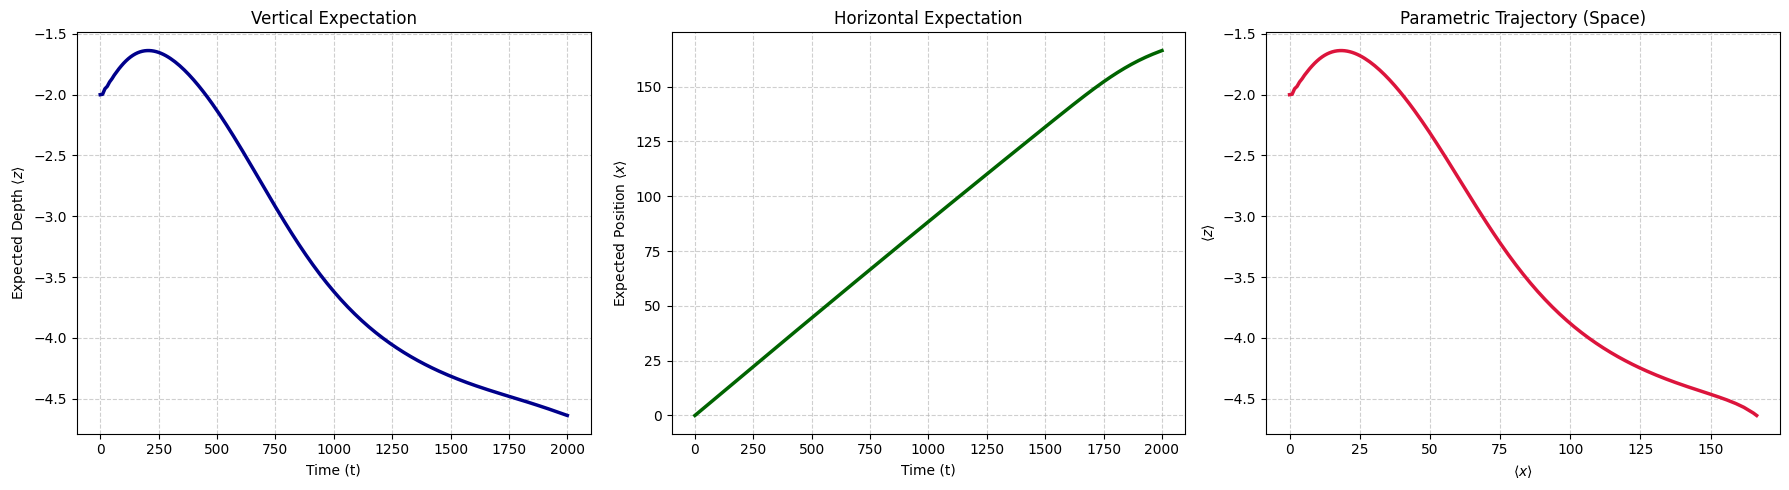

In [ ]:
import os
import matplotlib.pyplot as plt

# 1. Ensure the directory exists
save_dir = "./Average Plots"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory: {save_dir}")

# --- Plotting ---
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Vertical Depth vs Time
ax[0].plot(t_sub, mean_z, color='darkblue', linewidth=2.5)
ax[0].set_xlabel('Time (t)')
ax[0].set_ylabel(r'Expected Depth $\langle z \rangle$')
ax[0].set_title('Vertical Expectation')
ax[0].grid(True, linestyle='--', alpha=0.6)

# Plot 2: Horizontal Position vs Time
ax[1].plot(t_sub, mean_x, color='darkgreen', linewidth=2.5)
ax[1].set_xlabel('Time (t)')
ax[1].set_ylabel(r'Expected Position $\langle x \rangle$')
ax[1].set_title('Horizontal Expectation')
ax[1].grid(True, linestyle='--', alpha=0.6)

# Plot 3: Parametric Path (Real Space Trajectory)
ax[2].plot(mean_x, mean_z, color='crimson', linewidth=2.5, label='Mean Path')
# Mark Start and End points
# ax[2].scatter([mean_x[0]], [mean_z[0]], color='green', s=10, label='Start', zorder=5)
# ax[2].scatter([mean_x[-1]], [mean_z[-1]], color='black', s=10, label='End', zorder=5)

ax[2].set_xlabel(r'$\langle x \rangle$')
ax[2].set_ylabel(r'$\langle z \rangle$')
ax[2].set_title('Parametric Trajectory (Space)')
# ax[2].legend()
ax[2].grid(True, linestyle='--', alpha=0.6)
ax[2].set_aspect('auto', adjustable='box') 

plt.tight_layout()


timestamp = 2

# # 2. SAVE BEFORE SHOW
# # Using os.path.join handles Windows/Mac path slashes correctly
# save_path = os.path.join(save_dir, f"average_plot_{timestamp}.pdf")
# plt.savefig(save_path, dpi=150, bbox_inches='tight')
# print(f"Plot saved successfully to: {save_path}")

# 3. Now show it
plt.show()

Extracting Mean, Mode, and Median paths...


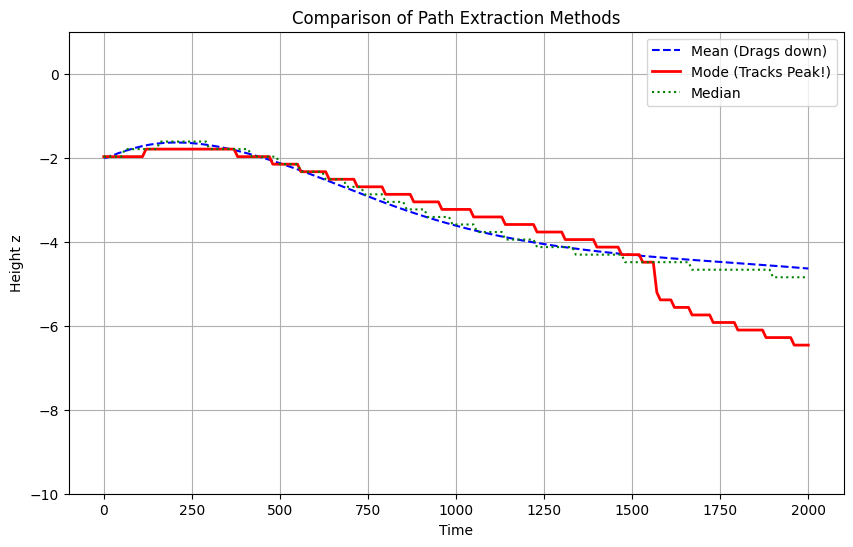

In [109]:
def extract_paths(solution, t_saved, xi_grid, z_grid):
    """
    Extracts Mean, Mode, and Median paths from the FP solution.
    Handles Co-Moving Frame transformation (xi -> x_lab).
    """
    Nt = len(t_saved)
    
    # Storage
    path_mean = {'x': np.zeros(Nt), 'z': np.zeros(Nt)}
    path_mode = {'x': np.zeros(Nt), 'z': np.zeros(Nt)}
    path_medi = {'x': np.zeros(Nt), 'z': np.zeros(Nt)}
    
    # Pre-calculate grids
    dxi = xi_grid[1] - xi_grid[0]
    dz  = z_grid[1] - z_grid[0]
    
    print("Extracting Mean, Mode, and Median paths...")
    
    for n in range(Nt):
        f = solution[n] # (Nxi, Nz, Nphi)
        
        # --- 1. GET MARGINALS ---
        # Sum over phi (and z or xi) to get 1D profiles
        p_xi = np.sum(f, axis=(1, 2)) # Shape (Nxi,)
        p_z  = np.sum(f, axis=(0, 2)) # Shape (Nz,)
        
        # Normalize (Safety)
        p_xi /= np.sum(p_xi) + 1e-16
        p_z  /= np.sum(p_z) + 1e-16
        
        # --- A. MEAN (Center of Mass) ---
        # Circular mean for Xi
        sin_avg = np.sum(np.sin(xi_grid) * p_xi)
        cos_avg = np.sum(np.cos(xi_grid) * p_xi)
        path_mean['x'][n] = np.arctan2(sin_avg, cos_avg)
        
        # Standard mean for Z
        path_mean['z'][n] = np.sum(z_grid * p_z)
        
        # --- B. MODE (Peak Tracking) ---
        # Find index of max value
        idx_xi_max = np.argmax(p_xi)
        idx_z_max  = np.argmax(p_z)
        
        path_mode['x'][n] = xi_grid[idx_xi_max]
        path_mode['z'][n] = z_grid[idx_z_max]
        
        # --- C. MEDIAN (50th Percentile) ---
        # Cumulative sum
        cdf_z = np.cumsum(p_z)
        # Find first index where CDF >= 0.5
        idx_z_med = np.searchsorted(cdf_z, 0.5)
        path_medi['z'][n] = z_grid[min(idx_z_med, len(z_grid)-1)]
        
        # (Median for circular xi is tricky, skipping for simplicity)
        path_medi['x'][n] = path_mean['x'][n] 

    # --- UNWRAP & TRANSFORM ---
    # Apply unwrapping to handle periodic jumps (0 -> 2pi)
    for p in [path_mean, path_mode, path_medi]:
        p['x'] = np.unwrap(p['x']) + t_saved # Transform back to Lab Frame

    return path_mean, path_mode, path_medi

# --- USAGE ---
p_mean, p_mode, p_medi = extract_paths(sol_data, t_sub, x_grid, z_grid)

# Plot Comparison
plt.figure(figsize=(10, 6))
plt.plot(t_sub, p_mean['z'], 'b--', label='Mean (Drags down)')
plt.plot(t_sub, p_mode['z'], 'r-',  lw=2, label='Mode (Tracks Peak!)')
plt.plot(t_sub, p_medi['z'], 'g:',  label='Median')
plt.title("Comparison of Path Extraction Methods")
plt.ylim(-10, 1)
plt.xlabel("Time")
plt.ylabel("Height z")
plt.legend()
plt.grid(True)
plt.show()

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def plot_summary_log(solution_list, t_array, x_grid, z_grid, phi_grid, num_snapshots=5):
    grids = (x_grid, z_grid, phi_grid)
    
    # 1. Select Indices
    N_data = len(solution_list)
    indices = np.linspace(0, N_data - 1, num_snapshots, dtype=int)
    snapshots = [compute_marginals(solution_list[i], grids) for i in indices]
    
    # 2. Find Global Limits for Log Scale
    # We set vmin to a small number (e.g., 1e-4 * max) to avoid log(0) errors
    global_max = max(np.max(s['xz']) for s in snapshots)
    global_min = global_max * 1e-4  # Show 4 orders of magnitude
    
    fig, axes = plt.subplots(3, num_snapshots, figsize=(3.5 * num_snapshots, 10), constrained_layout=True)
    
    for i, (idx, state) in enumerate(zip(indices, snapshots)):
        # Calculate time
        t_idx = int(idx * (len(t_array) - 1) / (N_data - 1))
        t = t_array[t_idx]
        
        # Row 1: Log-Scale f(x, z)
        ax = axes[0, i]
        # Adding a tiny epsilon to data prevents log(0) warnings
        data_xz = state['xz'].T + 1e-20 
        im1 = ax.contourf(x_grid, z_grid, data_xz, levels=np.logspace(np.log10(global_min), np.log10(global_max), 20), 
                          norm=LogNorm(vmin=global_min, vmax=global_max), cmap='viridis')
        ax.set_title(f't = {t:.2f}')
        if i == 0: ax.set_ylabel('z (Height)')
        
        # Row 2: Log-Scale f(x, phi)
        ax = axes[1, i]
        data_xphi = state['xphi'].T + 1e-20
        im2 = ax.contourf(x_grid, phi_grid, data_xphi, levels=np.logspace(np.log10(global_min), np.log10(global_max), 20),
                          norm=LogNorm(vmin=global_min, vmax=global_max), cmap='plasma')
        if i == 0: ax.set_ylabel('φ (Angle)')

        # Row 3: 1D Marginals (Standard Scale)
        ax = axes[2, i]
        ax.plot(x_grid, state['x'], 'b-', label='x')
        ax.plot(z_grid, state['z'], 'r-', label='z')
        # Check if Mass is conserved
        mass = np.sum(state['x']) * (x_grid[1]-x_grid[0])
        ax.text(0.05, 0.9, f"Mass: {mass:.2f}", transform=ax.transAxes, fontsize=8, color='k')
        
        ax.grid(True, alpha=0.3)
        if i == 0: ax.legend(loc='upper right')

    # Add Colorbar (Log format)
    plt.colorbar(im1, ax=axes[0, -1], label='Log Density')
    
    plt.show()

In [111]:
# plot_summary_log(sol_data, t_sub, x_grid, z_grid, phi_grid, num_snapshots=15)

In [112]:
def create_gif_manual(solution_list, t_array, x_grid, z_grid, phi_grid, filename="fp_evolution.gif", step=1):
    """
    Creates a GIF by stitching manually saved frames.
    
    Parameters
    ----------
    step : int
        Plot every 'step'-th frame. 
        step=1 plots every frame. step=5 plots frames 0, 5, 10, ...
    """
    
    # 1. SETUP DIRECTORIES
    temp_dir = "temp_frames"
    if os.path.exists(temp_dir):
        shutil.rmtree(temp_dir) 
    os.makedirs(temp_dir)
    
    grids = (x_grid, z_grid, phi_grid)
    N_total = len(solution_list)
    
    # 2. GLOBAL LIMITS
    # We calculate limits based on ALL data to ensure consistency, 
    # even if we skip frames for plotting.
    print("Calculating global limits...")
    # Using a stride here too for speed, but smaller than the plot stride if needed
    max_val = max(np.max(compute_marginals(solution_list[i], grids)['xz']) for i in range(0, N_total, max(1, step//2)))
    min_val = max_val * 1e-4
    levels = np.logspace(np.log10(min_val), np.log10(max_val), 20)
    norm = LogNorm(vmin=min_val, vmax=max_val)

    # 3. DEFINE INDICES TO PLOT
    # range(start, stop, step) handles the skipping logic
    indices_to_plot = range(0, N_total, step)
    print(f"Generating {len(indices_to_plot)} frames (skipping every {step-1} frames)...")
    
    filenames = []
    
    # 4. LOOP
    for i in indices_to_plot:
        # A. Prepare Data
        state = compute_marginals(solution_list[i], grids)
        t = t_array[i]
        
        # B. Create Figure
        fig, axes = plt.subplots(3, 1, figsize=(6, 10), constrained_layout=True)
        
        # Row 1: f(x, z)
        data_xz = state['xz'].T + 1e-20
        im1 = axes[0].contourf(x_grid, z_grid, data_xz, levels=levels, norm=norm, cmap='viridis')
        axes[0].set_ylabel('z (Height)')
        axes[0].set_title(f't = {t:.2f}')
        plt.colorbar(im1, ax=axes[0], label='Log Density')

        # Row 2: f(x, phi)
        data_xphi = state['xphi'].T + 1e-20
        im2 = axes[1].contourf(x_grid, phi_grid, data_xphi, levels=levels, norm=norm, cmap='plasma')
        axes[1].set_ylabel('φ (Angle)')
        plt.colorbar(im2, ax=axes[1], label='Log Density')

        # Row 3: 1D Marginals
        axes[2].plot(x_grid, state['x'], 'b-', label='x')
        axes[2].plot(z_grid, state['z'], 'r-', label='z')
        axes[2].legend(loc='upper right')
        axes[2].grid(True, alpha=0.3)
        axes[2].set_xlabel('Position')
        
        current_max = max(np.max(state['x']), np.max(state['z']))
        axes[2].set_ylim(0, current_max * 1.1 if current_max > 0 else 1)
        
        mass = np.sum(state['x']) * (x_grid[1]-x_grid[0])
        axes[2].text(0.05, 0.9, f"Mass: {mass:.2f}", transform=axes[2].transAxes)

        # C. Save Frame
        # Using {i:04d} ensures the frames are still sorted correctly 
        # even if i jumps from 0 to 5 to 10.
        frame_name = os.path.join(temp_dir, f"frame_{i:04d}.png")
        plt.savefig(frame_name, dpi=100)
        filenames.append(frame_name)
        
        plt.close(fig)
        
        print(f"Saved frame {i}/{N_total}", end='\r')

    print(f"\nStitching {len(filenames)} frames into {filename}...")
    
    # 5. STITCH
    # duration is seconds per frame. 
    # If we skip frames, we might want the GIF to play faster or slower depending on preference.
    with imageio.get_writer(filename, mode='I', duration=0.1) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
            
    # 6. CLEANUP
    shutil.rmtree(temp_dir)
    print("✅ Done!")

# --- EXECUTION ---
# Change 'step=5' to whatever number you prefer
create_gif_manual(sol_data, t_sub, x_grid, z_grid, phi_grid, 
                  filename='fp_fast_evolution.gif', 
                  step=2)

Calculating global limits...
Generating 101 frames (skipping every 1 frames)...
Saved frame 200/201
Stitching 101 frames into fp_fast_evolution.gif...
✅ Done!
